# Solution Analysis

In [1]:
import os
from pandas import DataFrame, read_csv, merge, Series

In [2]:
%load_ext autoreload
%autoreload 2

from src.utils import create_folder, clear_folder

In [3]:
from typing import Dict, List, Union, Set, Tuple

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

## Loading inputs

In [5]:
rules_folder: str = '../../_instances/covert2002/cov2002_clean/out/regulatory-rules/'

out_dir: str = f'{rules_folder.rsplit("/", maxsplit=2)[0]}/Multiple_Analysis'
clear_folder(out_dir)
create_folder(out_dir)


In [6]:
results_df: Dict[int, DataFrame] = {}
for filename in sorted(os.listdir(rules_folder)):
    filepath: str = rules_folder + filename
    result_id: int = int(filename.split('_')[1].strip('.csv'))
    results_df[result_id] = read_csv(filepath, index_col='node').fillna('')

## Computing clauses frequencies

In [7]:
def format_clause_name(clause: str) -> str:
    formatted_clause: str = clause
    formatted_clause = formatted_clause.replace(' ', '')
    formatted_clause = formatted_clause.replace('&', '+')
    return formatted_clause

## New functions

#### Converge the Dataframes

In [8]:
def converge_dfs(d_df: Dict[str,DataFrame]) -> List[Dict[str, Set[str]]]:
    every_clauses_set: List[Dict[str, Set[str]]] = []
    for i in range(len(d_df)):
        clauses_set : Dict[str, Set[str]] = {} 
        solution : DataFrame = d_df[i]
        for node in solution.index: 
            rules: List[str] = solution.loc[node][solution.loc[node] != ''].to_list() 
            for rule in rules:
                clauses_set.setdefault(node,set()).add(rule)  
        every_clauses_set.append(clauses_set) 
    return every_clauses_set

### Fuse all the rules

In [9]:
def fuse_sets(every_clauses_set: List[Dict[str, Set[str]]]) -> Dict[str, Set[str]]:
    uniq_set_rules = dict()
    for rule_X in every_clauses_set:
        for node in rule_X:
            if node not in uniq_set_rules:
                uniq_set_rules[node] = set()
            uniq_set_rules[node].update(c for c in rule_X[node])
    return uniq_set_rules

### Frequency

In [10]:
def parse_rule(rule:str)->List[str]:
    if '|' in rule:
        rule = rule[1:-1]
    rule_clauses: List[str] = rule.split(' | ')
    return rule_clauses

In [11]:
# def num_BN_per_rules_X(rules_X: Dict[str, Set[str]]) -> int:
#     nb_BN = 1
#     for node in rules_X:
#         nb_rule = 0
#         for rule in rules_X[node]:
#              nb_rule += 1
#         nb_BN *= nb_rule
#     return nb_BN

In [12]:
def num_BN_per_rules_X(rules_X: Dict[str, Set[str]]) -> int:
    nb_BN = 1
    for node in rules_X:
        nb_BN *= len(rules_X[node])
    return nb_BN

In [13]:
def num_rules_per_node(ens_rules_node:Set[str]) -> int:
    nb_rules = 0
    for rule in ens_rules_node:
        nb_rules += 1
    return nb_rules

In [14]:
def num_clause_per_node(ens_rules_node:Set[str],clause:str) -> int:
    nb_present = 0
    for rule in ens_rules_node:
        rule_clauses = parse_rule(rule)
        if clause in rule_clauses:
            nb_present += 1
    return nb_present

In [15]:
def calc_clause_per_rule_X(rules_X: Dict[str, Set[str]],ens_rules_node:Set[str],clause:str) -> float:
    return (num_BN_per_rules_X(rules_X) * num_clause_per_node(ens_rules_node,clause) / num_rules_per_node(ens_rules_node) )

In [16]:
def tot_num_BN(l_rules: List[Dict[str,Set[str]]]) -> int:
    tot = 0
    for rules_X in l_rules:
        tot += num_BN_per_rules_X(rules_X)
    return tot

In [17]:
def calc_freq(l_rules: List[Dict[str,Set[str]]]) -> Dict[str,Dict[str,float]]:
    d_freq: Dict[str,Dict[str,float]] = dict()
    for rule_X in l_rules:
        for node in rule_X:
            if node not in d_freq:
                d_freq[node] = dict()
            ens_node_clauses = set()
            for rule in rule_X[node]:
                rule_clauses = parse_rule(rule)
                ens_node_clauses.update(c for c in rule_clauses)
            
            for clause in ens_node_clauses:
                if clause not in d_freq[node]:
                    d_freq[node][clause] = calc_clause_per_rule_X(rule_X,rule_X[node],clause)
                else:
                    d_freq[node][clause] += calc_clause_per_rule_X(rule_X,rule_X[node],clause)

    for node in d_freq:
        for clause in d_freq[node]:
            d_freq[node][clause] /= tot_num_BN(l_rules)

    return d_freq

### Inclusive/Exclusive

In [18]:
def per_clause(ens_rules_node:Set[str],clause:str)-> Tuple[Set[str],Set[str],Set[str]]:
    is_with_clause: Set[str] = set() 
    inclusive: Set[str]  = set()
    exclusive: Set[str] = set()
    appearance: int = 0

    for rule in ens_rules_node:
        #print(rule)
        rule_clauses = parse_rule(rule)
        if clause in rule_clauses:
            
            #partie inclusive
            if inclusive == set() and appearance == 0:
                inclusive.update(c for c in rule_clauses if c != clause)
                appearance += 1
            else:
                inclusive.intersection_update(c for c in rule_clauses if c != clause)
            #partie with
            is_with_clause.update(c for c in rule_clauses if c != clause)
        #partie exclusive
        else:
            exclusive.update(c for c in rule_clauses)
        exclusive.difference_update(is_with_clause)
    return(is_with_clause,inclusive,exclusive)


In [19]:
def per_node(ens_rules_node: Set[str]) -> Dict[str,Tuple[Set[str], Set[str], Set[str]]]:
    d_clause_info = {}
    for rule in ens_rules_node:
        rules_clauses = parse_rule(rule)
        for clause in rules_clauses:
            d_clause_info[clause] = per_clause(ens_rules_node,clause)
    return d_clause_info
            

In [20]:
def total(uniq_set_rules: Dict[str, Set[str]]) -> Tuple[Dict[str,Dict[str,Set[str]]],Dict[str,Dict[str,Set[str]]],Dict[str,Dict[str,Set[str]]]]:
    d_with_tot = {}
    d_inclu_tot = {}
    d_exclu_tot = {}
    for ens_rules_node in uniq_set_rules:
        d_with_tot[ens_rules_node] = dict()
        d_inclu_tot[ens_rules_node] = dict()
        d_exclu_tot[ens_rules_node] = dict()
        temp = per_node(uniq_set_rules[ens_rules_node])
        for clause in temp:
            d_with_tot[ens_rules_node][clause] = temp[clause][0]
            d_inclu_tot[ens_rules_node][clause] = temp[clause][1]
            d_exclu_tot[ens_rules_node][clause] = temp[clause][2]
    return(d_with_tot,d_inclu_tot,d_exclu_tot)

### Analysis

In [21]:
def multiple_analysis(d_df: Dict[str,DataFrame]) -> DataFrame:
    mult_analysis_df: DataFrame = DataFrame(columns=['mapping', 'frequency', 'exclusive', 'inclusive'])

    all_clauses_set = converge_dfs(d_df)

    frequencies = calc_freq(all_clauses_set)

    uniq_set_rules = fuse_sets(all_clauses_set)
    inclusives = total(uniq_set_rules)[1]
    exclusives = total(uniq_set_rules)[2]

    for node in frequencies:
        for rule in frequencies[node]:
            rule_clauses = parse_rule(rule)
            for clause in rule_clauses:
                name: str = f'{node}<-{format_clause_name(clause.strip("(").strip(")"))}'

                inclu_str : str = '' 
                if inclusives[node][clause] != set():
                    inclu_names: Set[str] = {  
                        f'{node}<-{format_clause_name(c.strip("(").strip(")"))}' 
                        for c in inclusives[node][clause]}
                    inclu_str = ';'.join(inclu_names)
                else:
                    inclu_str = ''

                exclu_str : str = '' 
                if exclusives[node][clause] != set():
                    exclu_names: Set[str] = {  
                        f'{node}<-{format_clause_name(c.strip("(").strip(")"))}' 
                        for c in exclusives[node][clause]}
                    exclu_str = ';'.join(exclu_names)
                else:
                    exclu_str = ''

                if name not in mult_analysis_df['mapping'].values:
                    mult_analysis_df.loc[len(mult_analysis_df)] = \
                        {
                            'mapping': name, 
                            'frequency': frequencies[node][clause],
                            'exclusive': exclu_str,
                            'inclusive': inclu_str
                    }
    return mult_analysis_df

In [22]:
stats_export_path_mult: str = f'{out_dir}/stats-networks-multiple.csv'

In [23]:
mult_analysis_df = multiple_analysis(results_df)
mult_analysis_df.to_csv(stats_export_path_mult, index=False, float_format='%.5f')

### Histogram of the frequency of the mappings

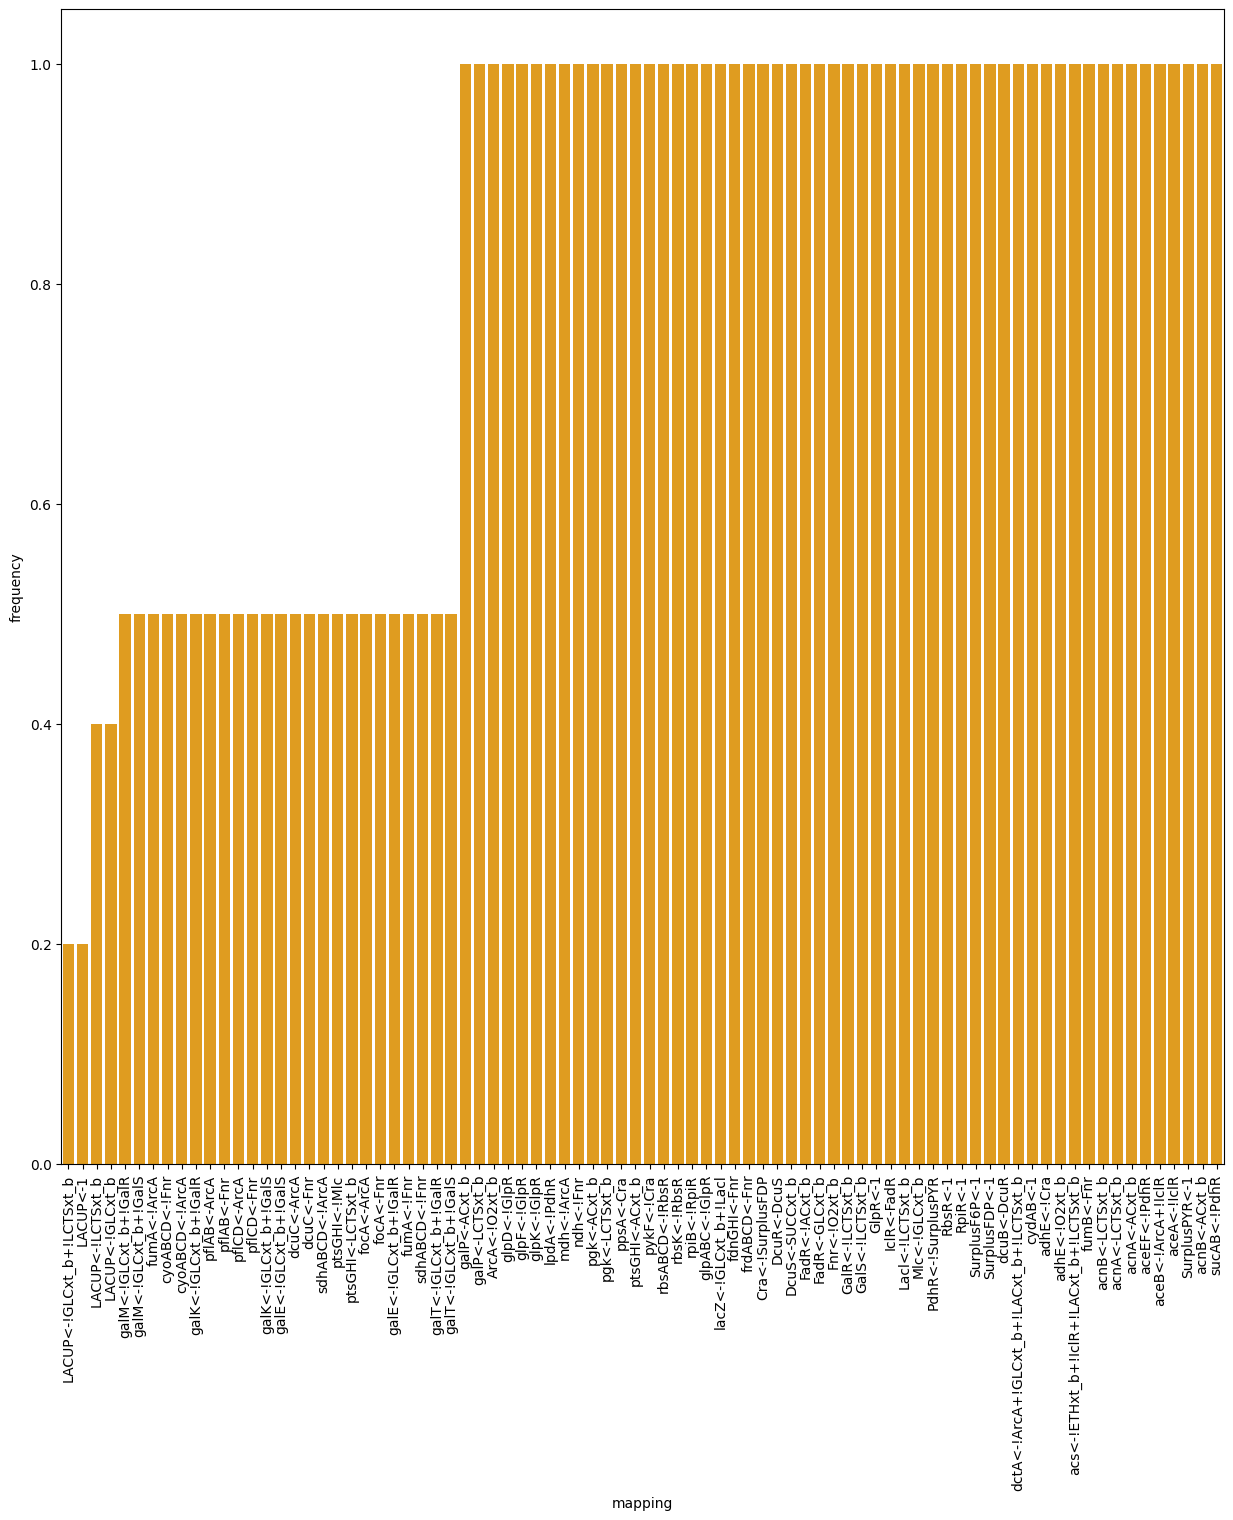

In [24]:
sorted_df = mult_analysis_df.sort_values(by='frequency',ascending=True)

plt.figure(figsize = (15, 15))
#freq_plot = sns.barplot(sorted_df,x=sorted_df['mapping'], y=sorted_df['frequency'], width=2, color='blue')
freq_plot = sns.barplot(sorted_df,x=sorted_df['mapping'], y=sorted_df['frequency'],width = 0.8, color = 'orange')

ax = freq_plot.axes
ax.tick_params(axis='x', rotation=90)
plt.show()